In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import train, predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 32

In [5]:
train_folder, val_folder = get_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

16980

# Model

In [6]:
from get_resnet18_with_sd import get_model

In [7]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [8]:
model, criterion, optimizer = get_model(class_weights=torch.FloatTensor(w/w.sum()))

In [9]:
# number of params in the model
count_params(model)

11307840

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 40
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=4, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

n_batches

531

In [11]:
%%time
all_losses, _ = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=531, n_validation_batches=80, 
    saving_step=None, lr_scheduler=lr_scheduler
)

1.00  5.869 5.441  0.069 0.021  0.172 0.078  94.621
2.00  4.811 5.354  0.173 0.045  0.365 0.127  93.498
3.00  4.416 5.156  0.234 0.080  0.443 0.248  93.470
4.00  4.046 5.017  0.281 0.146  0.511 0.337  93.359
5.00  4.046 4.989  0.283 0.097  0.510 0.302  93.407
6.00  3.652 4.580  0.323 0.241  0.565 0.487  93.536
7.00  3.446 3.972  0.354 0.397  0.593 0.653  93.906
8.00  3.361 3.948  0.366 0.366  0.609 0.634  93.485
9.00  3.286 3.477  0.377 0.464  0.619 0.719  93.706
10.00  3.151 3.404  0.400 0.469  0.638 0.723  94.631
11.00  2.914 3.131  0.432 0.533  0.674 0.770  93.410
12.00  2.856 3.301  0.445 0.484  0.687 0.740  93.672
13.00  2.843 2.988  0.444 0.523  0.686 0.773  93.208
14.00  2.749 3.655  0.462 0.443  0.702 0.698  93.429
15.00  2.677 3.447  0.467 0.445  0.715 0.687  93.514
16.00  2.562 2.898  0.490 0.526  0.728 0.758  93.652
Epoch    15: reducing learning rate of group 0 to 1.0000e-03.
Epoch    15: reducing learning rate of group 1 to 1.0000e-03.
Epoch    15: reducing learning rate o

# Loss/epoch plots

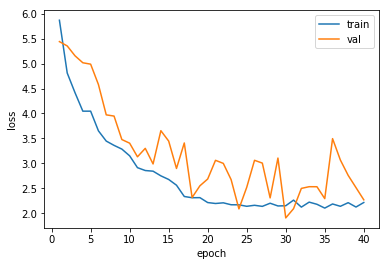

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

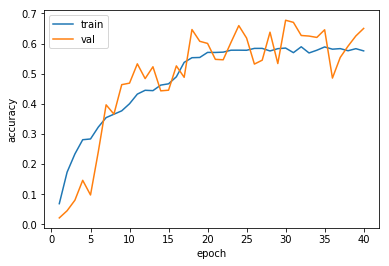

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

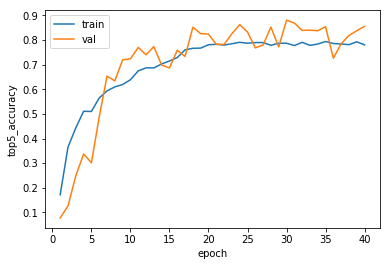

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Error analysis

### get human readable class names

In [15]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

### get all predictions and all misclassified images 

In [16]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [17]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)

In [18]:
n_errors = len(erroneous_targets)
n_errors

1790

### logloss and accuracies

In [19]:
log_loss(val_true_targets, val_predictions)

2.2502955038715187

In [20]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.650390625

In [21]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.75156250000000002, 0.80136718750000002, 0.83613281250000004, 0.85527343749999996, 0.90644531250000004]


### entropy of predictions

In [22]:
hits = val_predictions.argmax(1) == val_true_targets

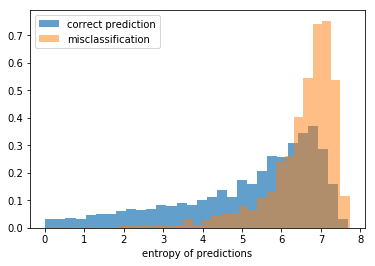

In [23]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

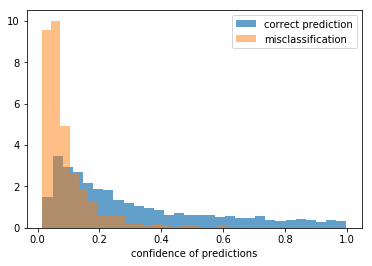

In [24]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

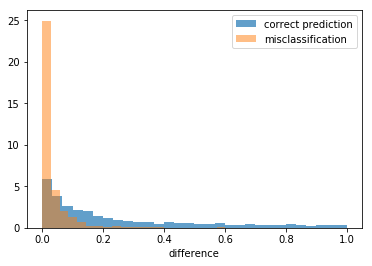

In [25]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

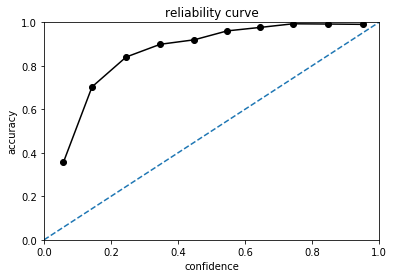

In [26]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

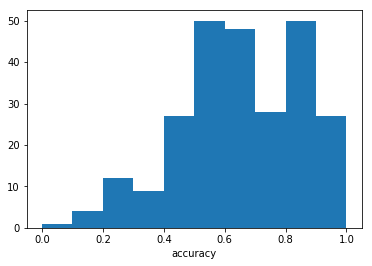

In [27]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [28]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

mailbox 0.0
playing-card 0.15
wheelbarrow 0.15
hot-dog 0.15
skateboard 0.15
screwdriver 0.2
knife 0.2
drinking-straw 0.2
sneaker 0.2
crab 0.25
spoon 0.25
rifle 0.3
welding-mask 0.3
iguana 0.3
coffin 0.3


### class accuracy vs. number of samples in the class

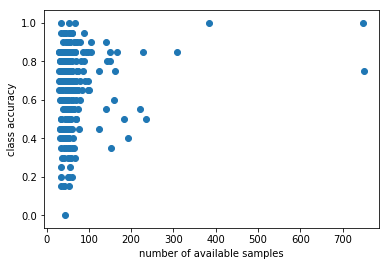

In [29]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [30]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('beer-mug', 'coffee-mug'),
 ('helicopter', 'airplanes'),
 ('hot-dog', 'spaghetti'),
 ('house-fly', 'cockroach'),
 ('iguana', 'fern'),
 ('jesus-christ', 'buddha'),
 ('kayak', 'speed-boat'),
 ('kayak', 'canoe'),
 ('killer-whale', 'dolphin'),
 ('minaret', 'smokestack'),
 ('mountain-bike', 'touring-bike'),
 ('paperclip', 'tweezer'),
 ('paper-shredder', 'washing-machine'),
 ('boom-box', 'vcr'),
 ('praying-mantis', 'grasshopper'),
 ('screwdriver', 'syringe'),
 ('screwdriver', 'baseball-bat'),
 ('skateboard', 'baseball-bat'),
 ('skyscraper', 'smokestack'),
 ('sneaker', 'tennis-shoes'),
 ('spoon', 'tweezer'),
 ('swan', 'goose'),
 ('breadmaker', 'washing-machine'),
 ('touring-bike', 'tricycle'),
 ('tuning-fork', 'tweezer'),
 ('tweezer', 'chopsticks'),
 ('yo-yo', 'frisbee'),
 ('toad', 'frog'),
 ('centipede', 'crab'),
 ('chimp', 'gorilla'),
 ('comet', 'galaxy'),
 ('cormorant', 'goose')]

### show some low entropy errors

In [31]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

6.5312137284254925

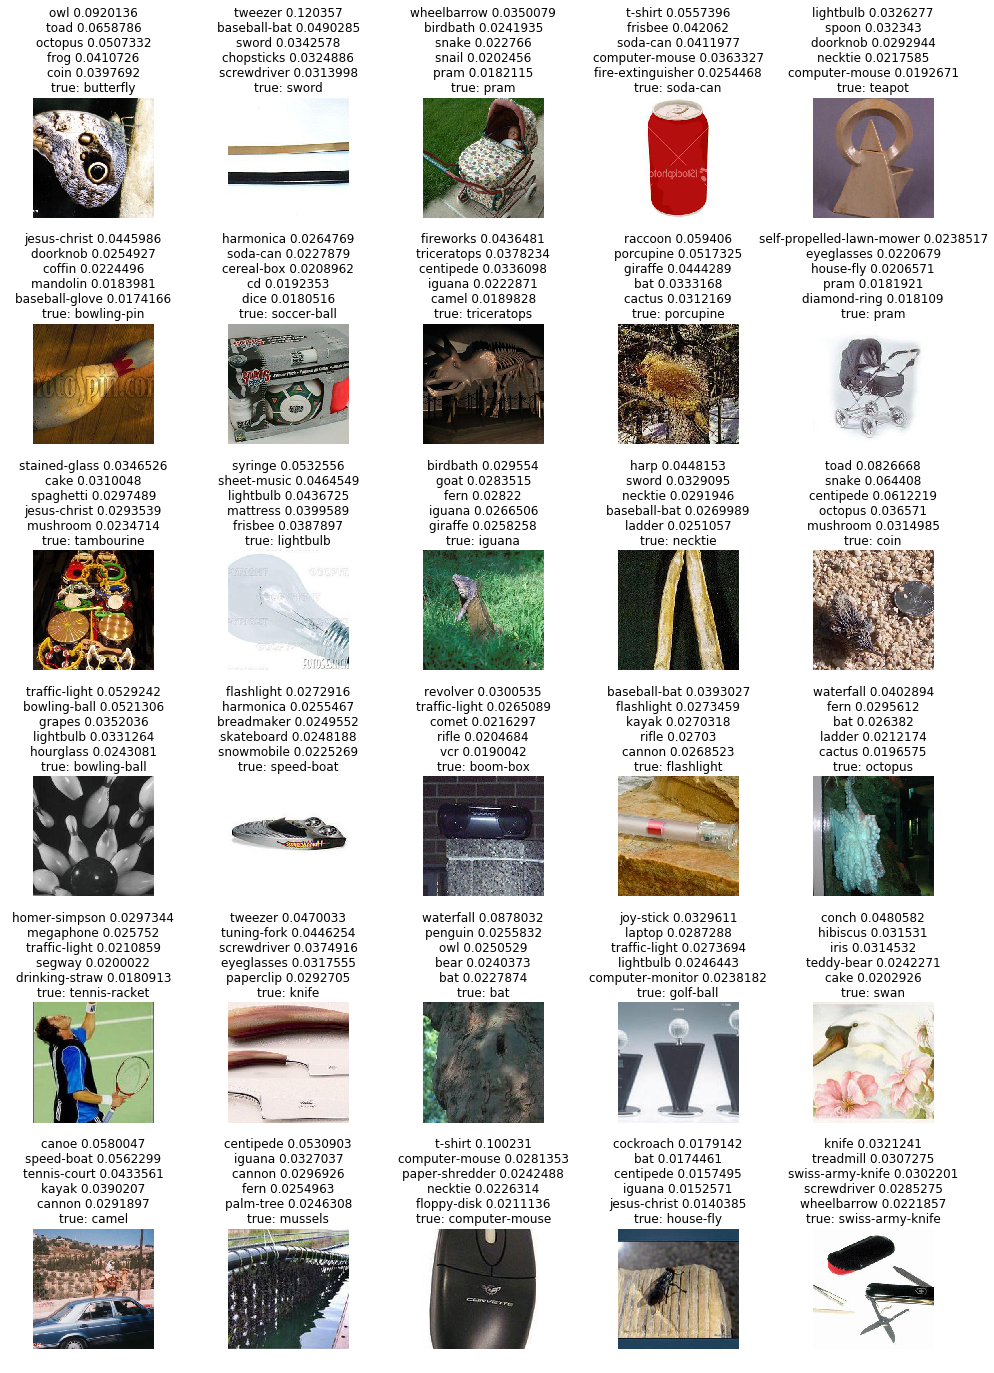

In [32]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

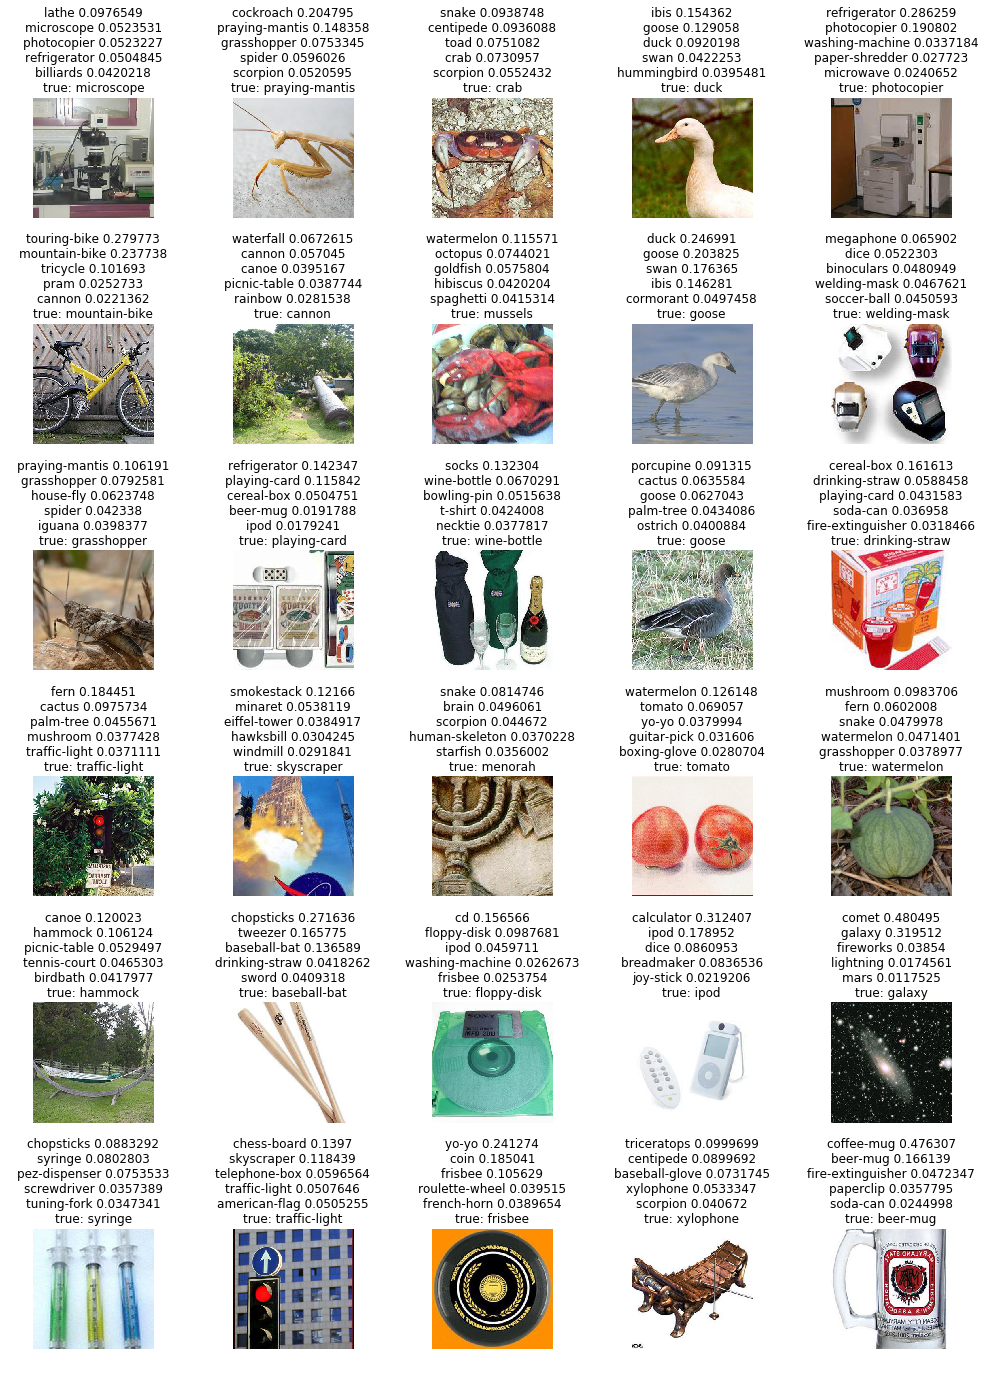

In [33]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)

# Save

In [34]:
model.cpu();
torch.save(model.state_dict(), 'resnet18_with_sd.pytorch_state')